# H-K Analysis over Mozambique 

This notebook demonstrates receiver function calculation and profile stacking with the help of the modified version of [rf](https://github.com/trichter/rf) package exists at: [rf_if](https://github.com/FadelI/rf) package using data freely available from Mozambique.

If you want to run this notebook locally, have a look at the repository [readme](https://github.com/trichter/notebooks).
Dependencies of this notebook are ObsPy, rf, h5py, obspyh5, and tqdm.

First we import the necessary functions and define file names for the inventory, earthquake and waveform files.

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
from obspy import read_inventory, read_events, UTCDateTime as UTC
from obspy.clients.fdsn import Client
from rf import read_rf, RFStream
from rf import get_profile_boxes, iter_event_data, IterMultipleComponents
from rf.imaging import plot_profile_map
from rf.profile import profile
from tqdm import tqdm
from numpy import absolute, zeros, max, linspace, arange
from IPython.display import clear_output
from rf.hk import hkZhu
from os.path import exists
from os import mkdir

home = "./6H/"
if  not exists(home):
    mkdir(home)

data = os.path.join(home, 'EQ_5_0')
invfile = data + '00_eq_stations.xml'
catfile = data + '00_eq_events.xml'
datafile = data + '01_eq_data.h5'
rffile = data + '02_rf_data.h5'
rfgood_autoqc = data + '02_rfgood_auto.h5' 
rfbad_autoqc = data + '02_rfbad_auto.h5' 
rfgood_visqc = data + '02_rfgood_vis.h5' 
rfbad_visqc = data + '02_rfbad_vis.h5' 
if not os.path.exists(data):  # create data folder if necessary
    os.mkdir(data)

In [2]:
import numba
import scipy

Inventory data and events of the year 2010 with magnitude between 5.5 and 6.5 are downloaded if necessary and plotted.

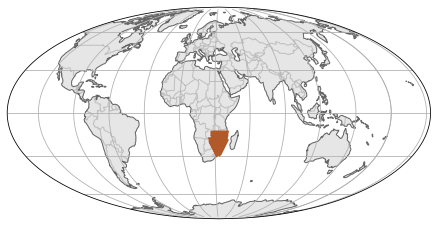

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


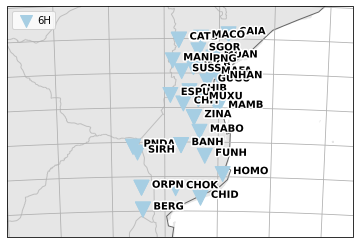

In [3]:
if not os.path.exists(invfile):
    client = Client("IRIS")
    inventory = client.get_stations(network='6H', channel='?H?', level='channel',
                                    minlatitude = -36.5, maxlatitude = -13.5, 
                                    minlongitude = 10, maxlongitude = 41)
    inventory.write(invfile, 'STATIONXML')
inventory = read_inventory(invfile)
inventory.plot(label=False)
fig = inventory.plot('local', color_per_network=True)

/home/jovyan/.local/lib/python3.8/site-packages/obspy/imaging/maps.py:762: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = Colorbar(cm_ax, scatter, cmap=colormap,


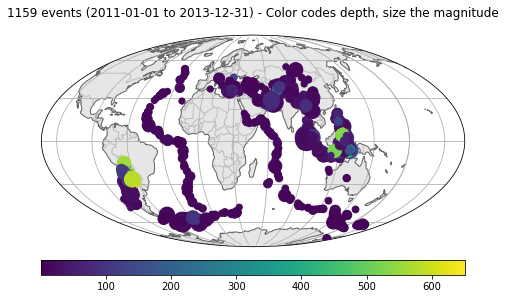

In [4]:
coords = inventory.get_coordinates('6H.MABO..BHZ')
lonlat = (coords['longitude'], coords['latitude'])
if not os.path.exists(catfile):
    client = Client("IRIS")
    kwargs = {'starttime': UTC('2011-01-01'), 'endtime': UTC('2014-01-01'), 
              'latitude': lonlat[1], 'longitude': lonlat[0],
              'minradius': 25, 'maxradius': 95,
              'minmagnitude': 5.2, 'maxmagnitude': 10}
    catalog = client.get_events(**kwargs)
    catalog.write(catfile, 'QUAKEML')
catalog = read_events(catfile)
fig = catalog.plot(label=None) 

Then, we download the waveform data with the `iter_event_data` iterator and save it to a `HDF5` file. The iterator automatically inserts the necessary headers into the stream by applying the `rfstats` function.

In [5]:
if not os.path.exists(datafile):
#     client = Client('GFZ')
    client = Client("IRIS")
    stream = RFStream()
    with tqdm() as pbar:
        for s in iter_event_data(catalog, inventory, client.get_waveforms, pbar=pbar):
            stream.extend(s)
    stream.write(datafile, 'H5')  
eqdata = read_rf(datafile)
for i in eqdata: print(i)
print(eqdata)

 20%|██        | 7093/34770 [16:32<6:18:28,  1.22it/s] /home/jovyan/RF/Package/rf/rf/util.py:98: UserWarning: Gaps or overlaps detected for event smi:service.iris.edu/fdsnws/event/1/query?eventid=9257404, station 6H.MACO..BH?.
  warn('Gaps or overlaps detected for event %s, station %s.'
100%|██████████| 34770/34770 [1:44:16<00:00,  5.56it/s]  


6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-18T11:07:17.022551Z | 50.0 Hz, 10001 samples | mag:5.5 dist:54.5 baz:27.2 slow:7.27
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-19T09:18:05.505339Z | 50.0 Hz, 10001 samples | mag:5.2 dist:64.8 baz:335.3 slow:6.53
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-20T10:02:02.874138Z | 50.0 Hz, 10001 samples | mag:6.3 dist:89.8 baz:220.3 slow:4.64
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-21T13:04:37.973906Z | 50.0 Hz, 10001 samples | mag:5.2 dist:87.0 baz:221.3 slow:4.85
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-23T22:54:14.516019Z | 50.0 Hz, 10001 samples | mag:5.2 dist:53.3 baz:22.7 slow:7.36
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-24T18:00:58.938990Z | 50.0 Hz, 10001 samples | mag:5.2 dist:46.8 baz:274.1 slow:7.83
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-24T22:29:53.579254Z | 50.0 Hz, 10001 samples | mag:5.3 dist:71.6 baz:28.0 slow:6.03
6H.BANH..BHE | -50.0s - 150.0s onset:2013-05-25T02:39:47.856893Z | 50.0 Hz, 10001 samples | m

We read the data again and iterate through it using `IterMultipleComponents`. This iterator returns a three component stream for each event and station. We filter the data, trim it relative to the P onset, calculate receiver functions and apply Ps moveout correction. After that the L component of one station and the Q component of some stations are plotted. The L component of the receiver function shows the expected peak at 0s.

In [3]:
eqdata = read_rf(datafile)
rfst = RFStream()
for stream3c in tqdm(IterMultipleComponents(eqdata, 'onset', 3)):
    if len(stream3c) != 3:
        continue    
    stream3c.trim2(-10, 40, 'onset')
    stream3c.detrend('linear')
    stream3c.detrend('demean')
    stream3c.taper(type = 'hann', max_percentage=0.07)
    stream3c.filter('bandpass', freqmin = 0.05, 
                  freqmax=2, corners=4, zerophase=True)
    # stream3c.rotate('NE->RT')
    stream3c.rf(deconvolve='iterative',  rotate='NE->RT', gauss=np.log(1.25))
    # stream3c.plot()
    rfst.extend(stream3c)
rfst.write(rffile, 'H5')

100%|██████████| 704/704 [20:45<00:00,  1.77s/it]


In [ ]:
rfst = read_rf(rffile, 'H5')

In [7]:
sta_attr = [["BANH",1.0, 80, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["BERG", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CAIA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CATA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CATB", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CHIB",  2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CHID", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CHIT", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["CHOK", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["ESPU", 1.1, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["FUNCH", 0.5, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["GUGU", 2.0, 85, 0.7, 0.2, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["HOMO", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["INCA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["INCB", 0.5, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MABO", 1.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MACO", 1.0, 85, 0.7, 0.2, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MAFA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MAMB", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MANI", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MUAN", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["MUXU", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["NHAN", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["ORPN", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["PNDA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["PNG",  2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["SGOR", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["SIRH", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["SUSS", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)],
            ["ZINA", 2.0, 85, 0.6, 0.3, 0.1, linspace(20,60,201), linspace(1.65,1.95,121)]]

sta_proc = sta_attr[8]
print(sta_proc)  

['CHOK', 2.0, 85, 0.6, 0.3, 0.1, array([ 20. ,  20.2,  20.4,  20.6,  20.8,  21. ,  21.2,  21.4,  21.6,
        21.8,  22. ,  22.2,  22.4,  22.6,  22.8,  23. ,  23.2,  23.4,
        23.6,  23.8,  24. ,  24.2,  24.4,  24.6,  24.8,  25. ,  25.2,
        25.4,  25.6,  25.8,  26. ,  26.2,  26.4,  26.6,  26.8,  27. ,
        27.2,  27.4,  27.6,  27.8,  28. ,  28.2,  28.4,  28.6,  28.8,
        29. ,  29.2,  29.4,  29.6,  29.8,  30. ,  30.2,  30.4,  30.6,
        30.8,  31. ,  31.2,  31.4,  31.6,  31.8,  32. ,  32.2,  32.4,
        32.6,  32.8,  33. ,  33.2,  33.4,  33.6,  33.8,  34. ,  34.2,
        34.4,  34.6,  34.8,  35. ,  35.2,  35.4,  35.6,  35.8,  36. ,
        36.2,  36.4,  36.6,  36.8,  37. ,  37.2,  37.4,  37.6,  37.8,
        38. ,  38.2,  38.4,  38.6,  38.8,  39. ,  39.2,  39.4,  39.6,
        39.8,  40. ,  40.2,  40.4,  40.6,  40.8,  41. ,  41.2,  41.4,
        41.6,  41.8,  42. ,  42.2,  42.4,  42.6,  42.8,  43. ,  43.2,
        43.4,  43.6,  43.8,  44. ,  44.2,  44.4,  44.6,  

In [8]:
for i in sta_attr:
    sta_stream = rfst.select(station = i[0])
    print(i[0], len(sta_stream))
#     for stream3c in tqdm(IterMultipleComponents(rfsta, 'onset', 3)): 
#     print(i[0])

NameError: name 'rfst' is not defined

In [53]:
 #%% Automatic QC
sta, snr, fitthr = sta_proc[0:3]
print("Process station %s"%sta)
rfsta = rfst.select(station = sta) 
rfautoQCgood = RFStream()
rfautoQCbad = RFStream()

for stream3c in tqdm(IterMultipleComponents(rfsta, 'onset', 3)):   
    #Check the least-square misfit
    fitall = 0 
    for tr in stream3c:
        fit = tr.stats.lsfit
        fitall = fit + fitall
    fitavg = fitall / 3
        
    #Check the signal to noise ratio
    bhrmax = max(absolute(stream3c.select(component = "R")[0].data))
    bhtmax = max(absolute(stream3c.select(component = "T")[0].data))
    print(fitavg, bhrmax, snr * bhtmax)
    if fitavg < fitthr:
        print("Least-squares fit is lower than %i"%fitthr)
        rfautoQCbad.extend(stream3c)
        stream3c.plot(color = "red", grid_color = 'black')
        continue
    elif bhrmax < snr * bhtmax:
        print("Signal to noise ratio is lower than %0.1f"%snr)
        rfautoQCbad.extend(stream3c)
        stream3c.plot(color = "orange")
        continue
    else:
        print("Good event")
        stream3c.plot()
        rfautoQCgood.extend(stream3c)
rfautoQCgood.write(rfgood_autoqc, 'H5')
rfautoQCbad.write(rfbad_autoqc, 'H5')

0it [00:00, ?it/s]

Process station CHOK


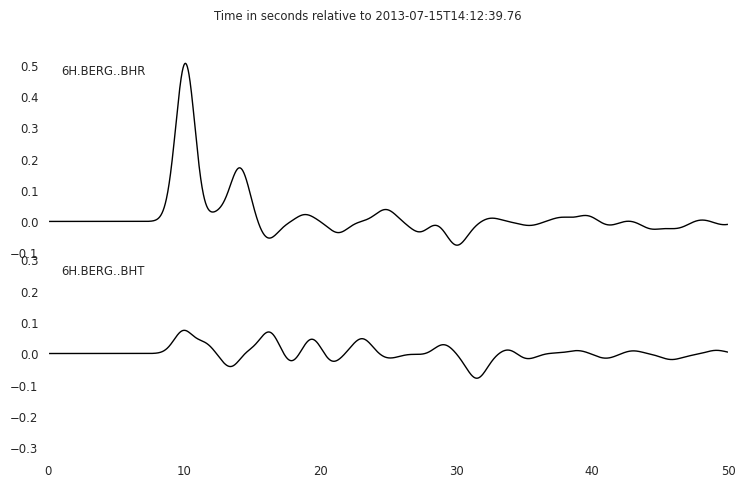

Press Enter if RF is good ot t to move to trash... 


In [36]:
#%% Visual QC
streamrt = RFStream()
rfvisQCgood = RFStream() 
rfvisQCbad = RFStream()
for stream3c in IterMultipleComponents(rfautoQCgood, key='onset', 
                                       number_components=3):
    clear_output(wait=True)
    streamrt = stream3c.select(component = "R")
    streamrt.extend(stream3c.select(component = "T"))
    streamrt.plot(type='relative')
    # streamrt.plot(equal_scale = True)
    resp = input("Press Enter if RF is good ot t to move to trash...")
    if resp == "t" or resp == "T":
        print("Move to trash")
        rfvisQCbad.extend(stream3c)
    else:
        print(resp)
        rfvisQCgood.extend(stream3c)

rfgood_visqc = data + '02_rfgood_vis_%s.h5'%sta 
rfbad_visqc = data + '02_rfbad_vis_%s.h5'%sta 
rfvisQCgood.write(rfgood_visqc, 'H5')
rfvisQCbad.write(rfbad_visqc, 'H5')

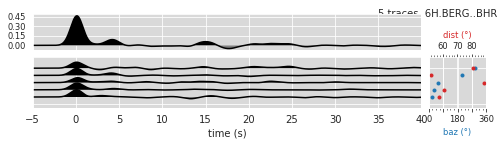

In [37]:
#%% Plot the radial visualy corrected RF
kw = {'trim': (-5, 40), 'fillcolors': ('black', 'gray'), 'trace_height': 0.1}
rfvisQCgood.select(component='R', station=sta).sort(['back_azimuth']).plot_rf(**kw)
plt.show()

BERG 0.22314 BHR
[ 20.   20.2  20.4  20.6  20.8  21.   21.2  21.4  21.6  21.8  22.   22.2
  22.4  22.6  22.8  23.   23.2  23.4  23.6  23.8  24.   24.2  24.4  24.6
  24.8  25.   25.2  25.4  25.6  25.8  26.   26.2  26.4  26.6  26.8  27.
  27.2  27.4  27.6  27.8  28.   28.2  28.4  28.6  28.8  29.   29.2  29.4
  29.6  29.8  30.   30.2  30.4  30.6  30.8  31.   31.2  31.4  31.6  31.8
  32.   32.2  32.4  32.6  32.8  33.   33.2  33.4  33.6  33.8  34.   34.2
  34.4  34.6  34.8  35.   35.2  35.4  35.6  35.8  36.   36.2  36.4  36.6
  36.8  37.   37.2  37.4  37.6  37.8  38.   38.2  38.4  38.6  38.8  39.
  39.2  39.4  39.6  39.8  40.   40.2  40.4  40.6  40.8  41.   41.2  41.4
  41.6  41.8  42.   42.2  42.4  42.6  42.8  43.   43.2  43.4  43.6  43.8
  44.   44.2  44.4  44.6  44.8  45.   45.2  45.4  45.6  45.8  46.   46.2
  46.4  46.6  46.8  47.   47.2  47.4  47.6  47.8  48.   48.2  48.4  48.6
  48.8  49.   49.2  49.4  49.6  49.8  50.   50.2  50.4  50.6  50.8  51.
  51.2  51.4  51.6  51.8  52.   52.2 

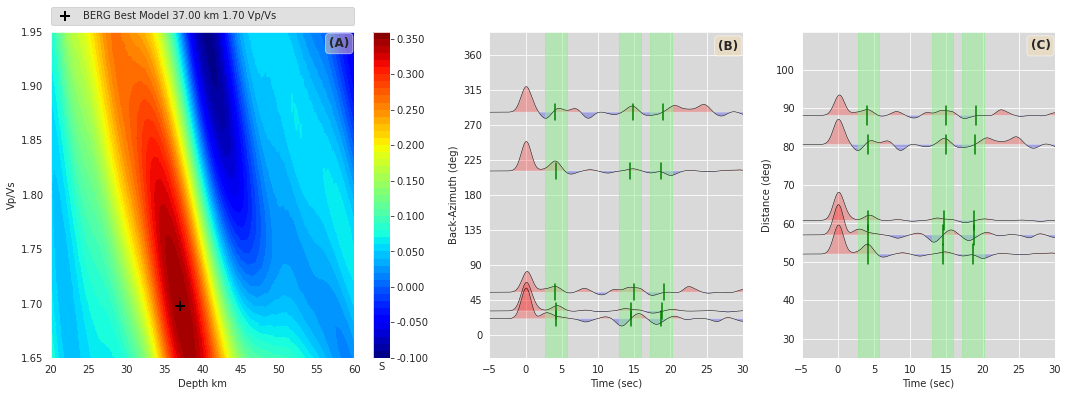

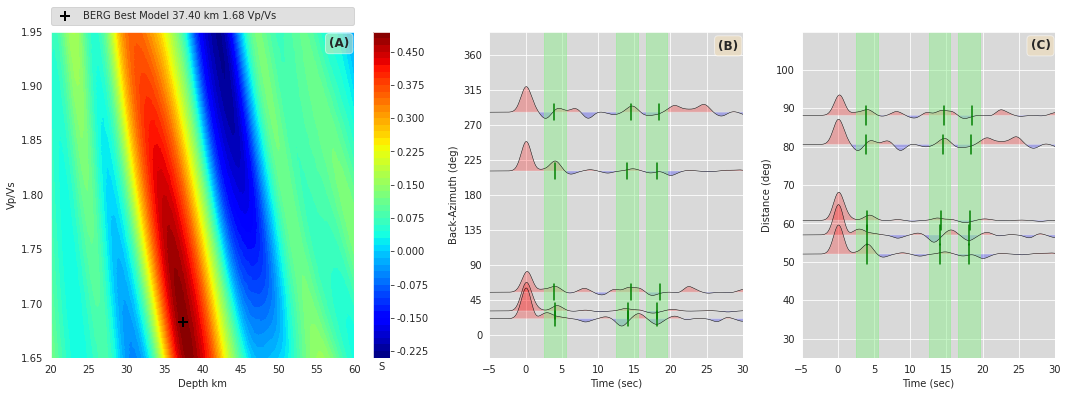

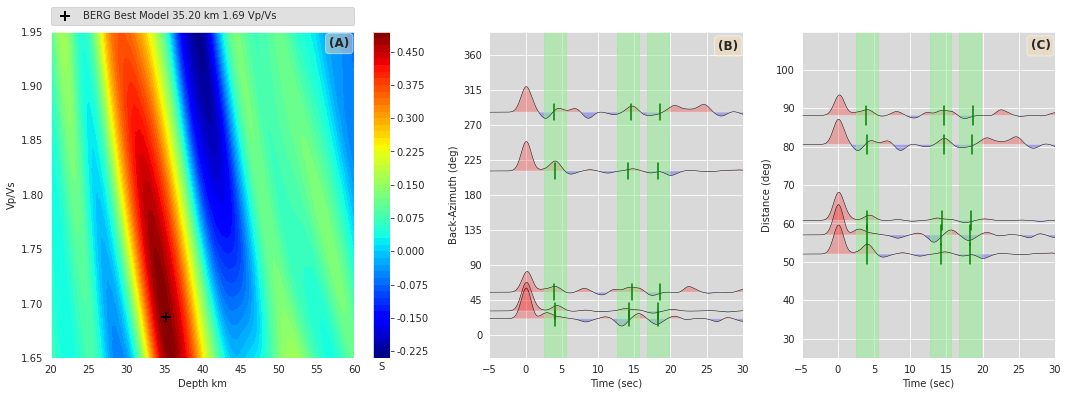

In [39]:
#%% Calculate the H-K
rfhk = rfvisQCgood.select(component='R', station=sta)
H, K= sta_proc[6:8]
w1, w2, w3 = sta_proc[3:6]
# H = arange(25,40,0.2)
hkZhu(rfhk, data, w1 = w1, w2 = w2, w3 = w3, K= K)
hkZhu(rfhk, data, w1 = w1, w2 = w1, w3 = w1, K= K, Vp = 6.7, suff="UncP", H=H)
hkZhu(rfhk, data, w1 = w1, w2 = w1, w3 = w1, K= K, Vp = 6.3, suff="UncN", H=H)